In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# True solution
def true_solution(x):
    return np.exp(-x)

# Generate synthetic data
X_data = np.linspace(0, 2, 100).reshape(-1, 1)
y_data = true_solution(X_data)

In [18]:
nn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(32, activation='tanh'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer='adam', loss='mse')
nn_model.fit(X_data, y_data, epochs=500, verbose=0)

In [19]:
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(1,)),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(32, activation='tanh'),
            tf.keras.layers.Dense(1)
        ])

    def call(self, x):
        return self.hidden(x)

    def get_derivative(self, x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            y = self.call(x)
        dy_dx = tape.gradient(y, x)
        return dy_dx

In [20]:
pinn = PINN()
optimizer = tf.keras.optimizers.Adam()

# Training data for physics
X_phys = tf.convert_to_tensor(np.linspace(0, 2, 100).reshape(-1, 1), dtype=tf.float32)
X_init = tf.convert_to_tensor([[0.0]], dtype=tf.float32)
y_init = tf.convert_to_tensor([[1.0]], dtype=tf.float32)

In [ ]:
@tf.function
def pinn_loss():
    with tf.GradientTape() as tape:
        y_pred = pinn(X_phys)
        dy_dx = pinn.get_derivative(X_phys)
        f = dy_dx + y_pred
        physics_loss = tf.reduce_mean(tf.square(f))
        y0_pred = pinn(X_init)
        ic_loss = tf.reduce_mean(tf.square(y0_pred - y_init))
        return physics_loss + ic_loss

In [22]:
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        loss = pinn_loss()
    grads = tape.gradient(loss, pinn.trainable_variables)
    optimizer.apply_gradients(zip(grads, pinn.trainable_variables))
    return loss

In [23]:
for epoch in range(1000):
    loss = train_step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.numpy():.5f}")

Epoch 0, Loss: 1.06457
Epoch 100, Loss: 0.00419
Epoch 200, Loss: 0.00158
Epoch 300, Loss: 0.00078
Epoch 400, Loss: 0.00064
Epoch 500, Loss: 0.00054
Epoch 600, Loss: 0.00045
Epoch 700, Loss: 0.00038
Epoch 800, Loss: 0.00031
Epoch 900, Loss: 0.00025


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


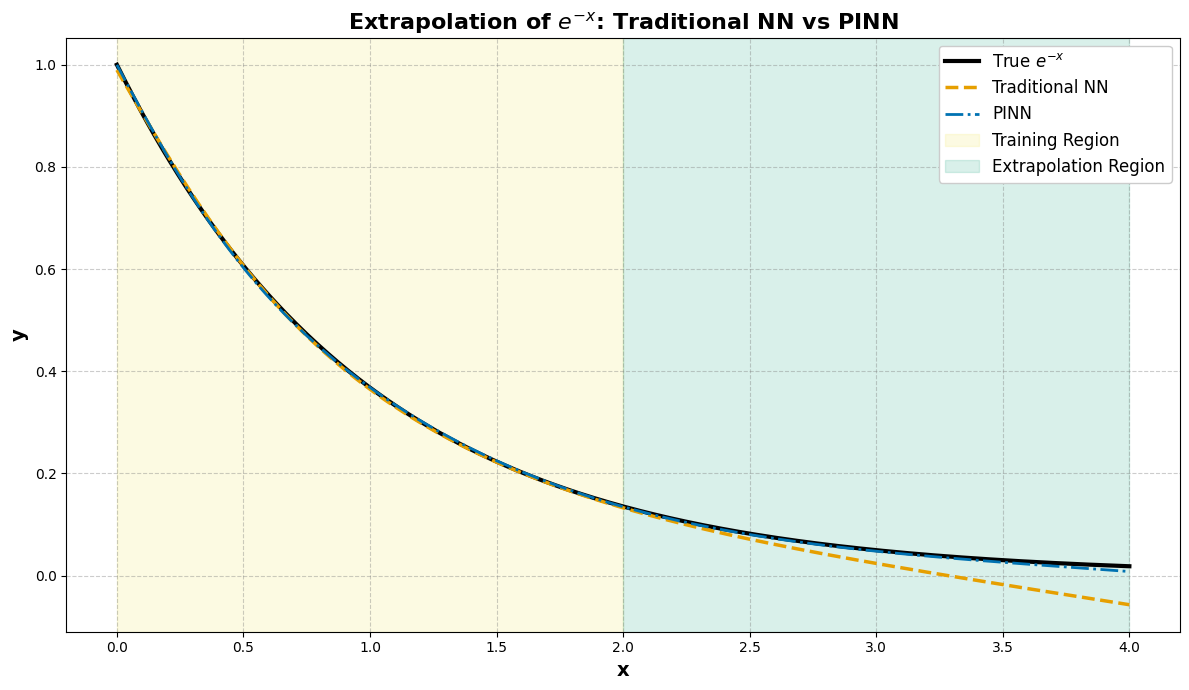

In [48]:
# === Extended Prediction ===
X_test = np.linspace(0, 4, 400).reshape(-1, 1).astype(np.float32)
y_true = true_solution(X_test)

y_nn = nn_model.predict(X_test)
y_pinn = pinn(X_test).numpy()

# === Plotting with White Background ===
plt.style.use('default')  # Reset to default white background
plt.figure(figsize=(12, 7), facecolor='white', edgecolor='black')

# Plot lines with publication-quality colors
plt.plot(X_test, y_true, 'k-', label='True $e^{-x}$', linewidth=3)  # Black for ground truth
plt.plot(X_test, y_nn, '#E69F00', linestyle='--', label='Traditional NN', linewidth=2.5)  # Orange
plt.plot(X_test, y_pinn, '#0072B2', linestyle='-.', label='PINN', linewidth=2)  # Blue

# Region shading (subtle and printer-friendly)
plt.axvspan(0, 2, color='#F0E442', alpha=0.15, label='Training Region', zorder=1)  # Light yellow
plt.axvspan(2, 4, color='#009E73', alpha=0.15, label='Extrapolation Region', zorder=1)  # Light green

# Professional styling
plt.legend(loc='best', fontsize=12, framealpha=1, edgecolor='0.8')
plt.xlabel("x", fontsize=14, fontweight='bold', color='black')
plt.ylabel("y", fontsize=14, fontweight='bold', color='black')
plt.title("Extrapolation of $e^{-x}$: Traditional NN vs PINN", 
          fontsize=16, fontweight='bold', color='black')

# Custom grid
plt.grid(True, linestyle='--', color='gray', alpha=0.4)

# Axis and border styling
for spine in plt.gca().spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.8)

plt.tight_layout()
plt.show()